In [453]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lasio
import os
import glob
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from fastdtw import fastdtw
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import networkx as nx
import scipy.interpolate
import time

In [454]:
# directory on personal computer
ruta = 'C:/Users/User/Desktop/Pan American Energy/reference scripts/initial'
os.chdir(ruta)

ruta_logs = ruta + "/Datos VH_III"
ruta_archivo = ruta_logs +"/Datos VH_III.xlsx"

las_files = glob.glob(os.path.join(ruta_logs, '*.las'))
log_files = glob.glob(os.path.join(ruta_logs, '*.log'))


# Create a directed graph
G = nx.DiGraph()

# get data from excel
well_data = pd.read_excel(ruta_archivo)

def las_to_node(G, filename, col_name):
    node_name = os.path.splitext(os.path.basename(filename))[0]
    las = lasio.read(filename)
    las_df = las.df().dropna()
    las_df = las_df.reset_index()
    new_las = pd.DataFrame(columns=["DEPTH",'RES_DEEP'])
    new_las["DEPTH"] = las_df["DEPTH"]
    new_las["RES_DEEP"] = las_df[col_name]

    coord_data = well_data[well_data["Nombre"]==node_name]
    x_coord = coord_data.iloc[0, 5]
    y_coord = coord_data.iloc[0, 6]

    G.add_node(node_name, data=new_las, pos=(x_coord, y_coord))

    # Add tops
    tops_data = pd.read_excel(ruta_archivo, sheet_name=node_name)
    tops_data = tops_data.drop(index=0)

    a = tops_data[["Capa", "Top"]].copy()
    a.rename(columns={"Top": "Ref"}, inplace=True)

    

    b=tops_data[["Capa", "Base"]].copy()
    b.rename(columns={"Base": "Ref"}, inplace=True)
    resultado = pd.concat([a, b], ignore_index=True)

    tops_vals = resultado.sort_values(by='Ref', ascending=True).reset_index().dropna()

    # print(f"Resultados {node_name}")
    # print(resultado.head(5))
    # print()



    G.nodes[node_name]["known_tops"]=tops_vals.copy()

def log_to_node(G, filename, col_name):
    log_data = []
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    # Identify header and determine the indices of the columns of interest
    header = lines[0].strip().split()
    depth_idx = header.index("DEPTH")
    col_idx = header.index(col_name)

    new_log = pd.DataFrame(columns=["DEPTH",'RES_DEEP'])

    new_log["DEPTH"] = lines[depth_idx]
    new_log["RES_DEEP"] = lines[col_idx]

    print(lines[2])


las_to_node(G, las_files[0], "HT90")
las_to_node(G, las_files[1], "HT90")
las_to_node(G, las_files[2], "HDRS")

#log_to_node(G, log_files[0], "M2R9")




Un grafo ciclico con 3 nodos, esto podria cambiar en el futuro

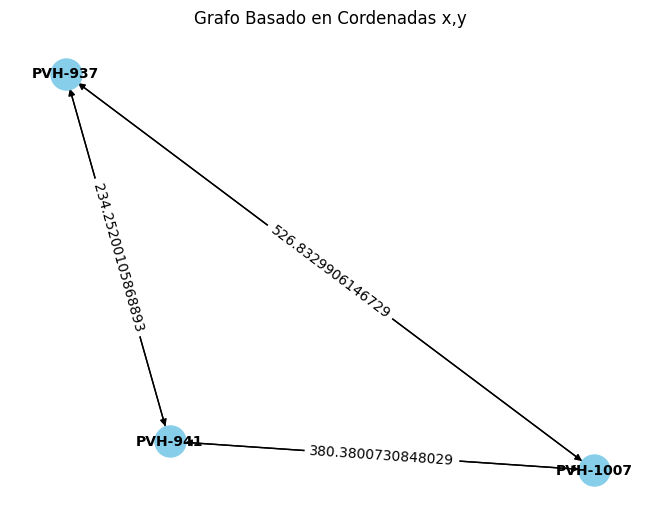

In [455]:
#%%
# Function to calculate geodesic distance between two points
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

def euclidian_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

threshold_distance = 2000  # Define a distance threshold

for node1, data1 in G.nodes(data=True):
    for node2, data2 in G.nodes(data=True):
        if node1 != node2:
            pos1 = data1['pos']
            pos2 = data2['pos']
            distance = euclidian_distance(pos1[0], pos1[1], pos2[0], pos2[1])
            if distance <= threshold_distance:
                G.add_edge(node1, node2, weight=distance)

# Visualize the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.title("Grafo Basado en Cordenadas x,y")
plt.show()

In [456]:
print(G.nodes["PVH-937"]["data"].head(5))

     DEPTH  RES_DEEP
0  874.575    2.6455
1  874.700    2.5251
2  874.825    2.3703
3  874.950    2.2122
4  875.075    2.1082


Esto es el algoritmo principal. *dtw_calc* hace la computacion principal. *calc_tops* actualiza los datos de tops del siguiente nodo. *profiles_comparison* crea un grafico del dtw path

In [457]:

# helper methods
def normalize_array(arr):
    reshaped_arr = arr.reshape(-1, 1)
    scaler = MinMaxScaler()
    normalized_arr = scaler.fit_transform(reshaped_arr)
    return normalized_arr

def custom_distance(p1, p2):
    return np.abs(p1 - p2) **(1/ 4.3)



# node 1 is the curernt node
# node 2 is the node you attempt to move to
# function gets a dataframe with the predicted depths, assigns to "tops" label in node
def calc_tops(G, node1, node2):

    # create a new dataframe that takes the values of node2 where the "capa" value is the same as in node1
    
    
    correla, df1, df2 = dtw_calc(G, node1, node2)
    print("correla tuple", len(correla))
    
    df_result = pd.DataFrame(columns=["Capa",'Ref'])

    # create a list of j values for unique i values
    j_values_dict = {}

    for i, j in correla:
        
        if i not in j_values_dict:
            j_values_dict[i] = []
        j_values_dict[i].append(j)

    rows_to_add = []
    # obtaining a 1 to 1 relationship between i and j by averaging 
    for i, j_values in j_values_dict.items():
        i_depth = df1["DEPTH"].iloc[i]
        j_depths = [df2["DEPTH"].iloc[j] for j in j_values]
        # averaging j values
        j_depth = np.mean(j_depths) # averaging, may want to try a different method later
        #print(f'i = {i_depth}, j = {j_depths}') #print the j values for each corresponding i value
        rows_to_add.append({'Ref': j_depth})

    #capas = G.nodes[node1]["known_tops"]["Capa"]
    
    df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)
    #df_result["Capa"] = capas

    # assign new top values to the node
    G.nodes[node2]["tops"]=df_result
    #print(G.nodes[node2]["tops"])


def dtw_calc(G, node1, node2):
    tolerance = 0.05
    df1 = G.nodes[node1]["data"] # RES_DEEP data for node1
    #tops1 = G.nodes[node1]["known_tops"] # Tops data for node1

    #filter the tops data to only include the tops present in both datasets
    capas1_names = G.nodes["PVH-937"]["known_tops"]["Capa"]  # List of names
    capas2 = G.nodes["PVH-941"]["known_tops"].copy()
    tops1 = capas2[capas2["Capa"].isin(capas1_names)]
    num_matches = tops1.shape[0] # This is how many points of interest are in the dataset, this should be the size of the output too
    print("Number of top values, ideally:", num_matches)

    df2 = G.nodes[node2]["data"] # RES_DEEP data for node2



    # mark rows within the tolerance range of any top
    change = 1
    for index_df1, row_df1 in df1.iterrows():
        depth_value = row_df1['DEPTH']
        matches = tops1['Ref'].apply(lambda x: np.abs(x - depth_value) <= tolerance)
        
        if matches.any():
            df1.at[index_df1, 'Present'] = 1
            #print("marking...", change)
            change = change+1

    print("matches", matches.shape[0])
    G.nodes[node1]["is_top"] = df1[df1['Present'] == 1] # store the filtered rows near the caps into the graph
    print("marked df", df1[df1['Present'] == 1].shape[0])
    prof1 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"][0] - 50
    prof2 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"].iloc[-1] + 50
    df1 = df1[(df1['DEPTH'] > prof1) & (df1['DEPTH'] < prof2)].reset_index()
    df2 = df2[(df2['DEPTH'] > prof1) & (df2['DEPTH'] < prof2)].reset_index()


    # normalize res deep in df1 and df2
    w1 = np.array(df1['RES_DEEP'].dropna())
    w2 = np.array(df2['RES_DEEP'].dropna())
    # might need to use normalized values later, not rn tho
    w1_normalized = normalize_array(w1)
    w2_normalized = normalize_array(w2)


    ref = df1[df1["Present"] == 1]
    print("ref", ref.shape[0])
    distance, path = fastdtw(w1, w2, dist=custom_distance)
    # distance, path = fastdtw(w1_normalized, w2_normalized, dist=custom_distance) Might need to normalize later
    correla = [tupla for tupla in path if tupla[0] in ref.index]

    #mark tops in df2, this block of code is not necessary
    # correla2 = [tupla[1] for tupla in correla]
    # df2["is_top"] = 0
    # for elemento in correla2:
    #     if elemento in df2.index:
    #         df2.loc[elemento, "is_top"] = 1
    # G.nodes[node2]["is_top"] = df2[df2["is_top"] == 1]
    # G.nodes[node2]["Procesados"] = df2
    return correla, df1, df2


def profiles_comparison(G, node1, node2, r):
    correla, df1, df2 = dtw_calc(G, node1, node2)

    offset = 50
    plt.figure(figsize=(10, 6))

    # Plot df1
    plt.plot(df1["DEPTH"], df1["RES_DEEP"], label=node1, color='blue')

    # Plot df2 with offset
    plt.plot(df2["DEPTH"], df2["RES_DEEP"] + offset, label=node2, color='orange')

    for i, j in correla:
        # Plot the DTW path
        plt.plot([df1["DEPTH"].iloc[i], df2["DEPTH"].iloc[j]], [df1["RES_DEEP"].iloc[i], df2["RES_DEEP"].iloc[j] + offset], color='red', linestyle='-')

    plt.title(f"Reference Node: {node1}, Prediction Node: {node2}")
    plt.xlabel('Depth (m)')
    if r:
        plt.xlim(r[0], r[1])
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()


Aqui se corre el algoritmo, calculando los topes de 1499 usando los datos de 1318

Number of top values, ideally: 44
marking... 1
marking... 2
marking... 3
marking... 4
marking... 5
marking... 6
marking... 7
marking... 8
marking... 9
marking... 10
marking... 11
marking... 12
marking... 13
marking... 14
marking... 15
marking... 16
marking... 17
marking... 18
marking... 19
marking... 20
marking... 21
marking... 22
marking... 23
marking... 24
marking... 25
marking... 26
marking... 27
marking... 28
marking... 29
marking... 30
marking... 31
marking... 32
marking... 33
marking... 34
marking... 35
marking... 36
marking... 37
marking... 38
marking... 39
marking... 40
marking... 41
marking... 42
matches 44
marked df 42
ref 42
correla tuple 45
Number of top values, ideally: 44
marking... 1
marking... 2


C:\Users\User\AppData\Local\Temp\ipykernel_29744\1949279167.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)


marking... 3
marking... 4
marking... 5
marking... 6
marking... 7
marking... 8
marking... 9
marking... 10
marking... 11
marking... 12
marking... 13
marking... 14
marking... 15
marking... 16
marking... 17
marking... 18
marking... 19
marking... 20
marking... 21
marking... 22
marking... 23
marking... 24
marking... 25
marking... 26
marking... 27
marking... 28
marking... 29
marking... 30
marking... 31
marking... 32
marking... 33
marking... 34
marking... 35
marking... 36
marking... 37
marking... 38
marking... 39
marking... 40
marking... 41
marking... 42
matches 44
marked df 42
ref 42


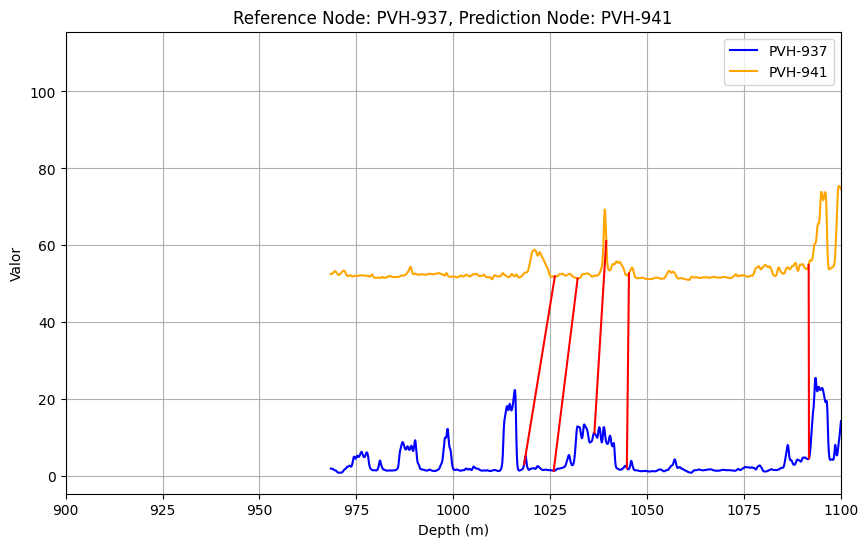

Number of top values, ideally: 44
marking... 1
marking... 2
marking... 3
marking... 4
marking... 5
marking... 6
marking... 7
marking... 8
marking... 9
marking... 10
marking... 11
marking... 12
marking... 13
marking... 14
marking... 15
marking... 16
marking... 17
marking... 18
marking... 19
marking... 20
marking... 21
marking... 22
marking... 23
marking... 24
marking... 25
marking... 26
marking... 27
marking... 28
marking... 29
marking... 30
marking... 31
marking... 32
marking... 33
marking... 34
marking... 35
marking... 36
marking... 37
marking... 38
marking... 39
marking... 40
marking... 41
marking... 42
matches 44
marked df 42
ref 42


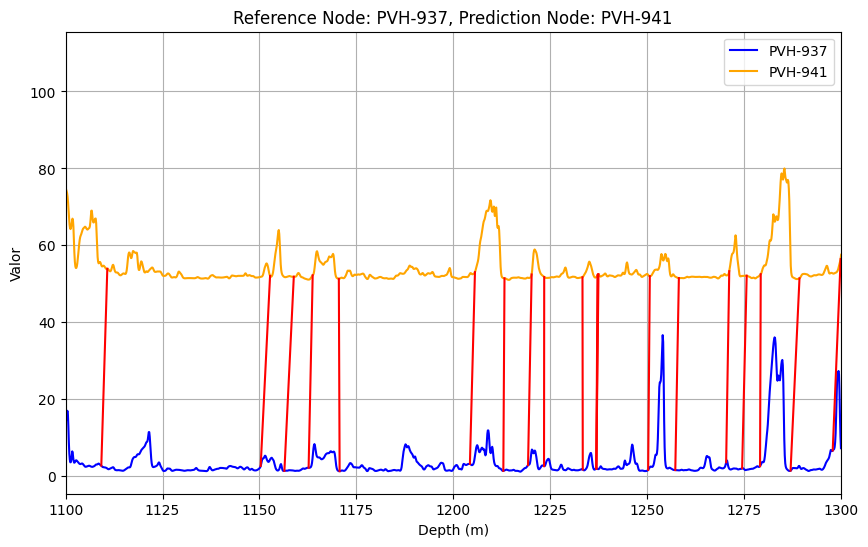

Number of top values, ideally: 44
marking... 1
marking... 2
marking... 3
marking... 4
marking... 5
marking... 6
marking... 7
marking... 8
marking... 9
marking... 10
marking... 11
marking... 12
marking... 13
marking... 14
marking... 15
marking... 16
marking... 17
marking... 18
marking... 19
marking... 20
marking... 21
marking... 22
marking... 23
marking... 24
marking... 25
marking... 26
marking... 27
marking... 28
marking... 29
marking... 30
marking... 31
marking... 32
marking... 33
marking... 34
marking... 35
marking... 36
marking... 37
marking... 38
marking... 39
marking... 40
marking... 41
marking... 42
matches 44
marked df 42
ref 42


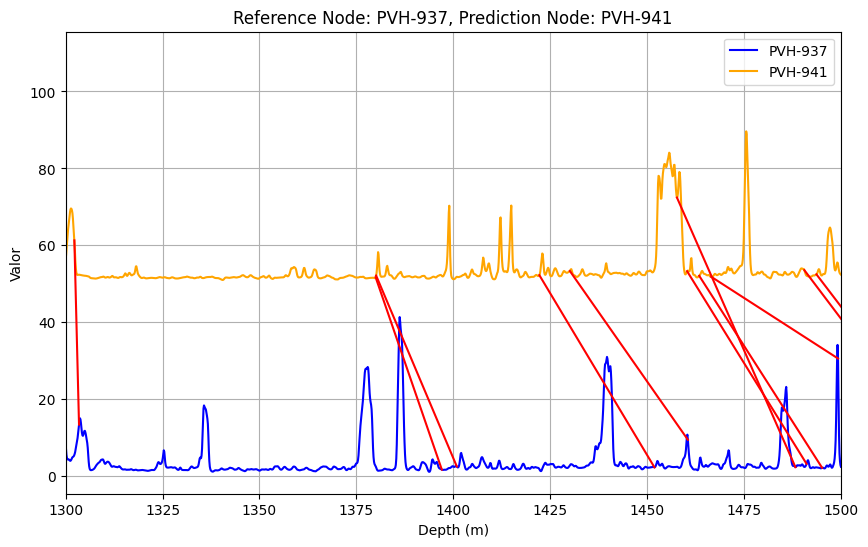

Number of top values, ideally: 44
marking... 1
marking... 2
marking... 3
marking... 4
marking... 5
marking... 6
marking... 7
marking... 8
marking... 9
marking... 10
marking... 11
marking... 12
marking... 13
marking... 14
marking... 15
marking... 16
marking... 17
marking... 18
marking... 19
marking... 20
marking... 21
marking... 22
marking... 23
marking... 24
marking... 25
marking... 26
marking... 27
marking... 28
marking... 29
marking... 30
marking... 31
marking... 32
marking... 33
marking... 34
marking... 35
marking... 36
marking... 37
marking... 38
marking... 39
marking... 40
marking... 41
marking... 42
matches 44
marked df 42
ref 42


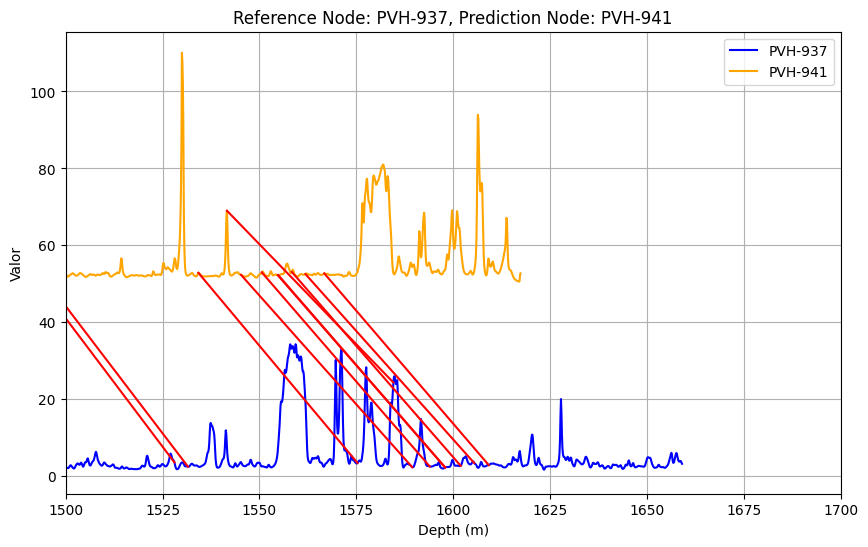

Number of top values, ideally: 44
marking... 1
marking... 2
marking... 3
marking... 4
marking... 5
marking... 6
marking... 7
marking... 8
marking... 9
marking... 10
marking... 11
marking... 12
marking... 13
marking... 14
marking... 15
marking... 16
marking... 17
marking... 18
marking... 19
marking... 20
marking... 21
marking... 22
marking... 23
marking... 24
marking... 25
marking... 26
marking... 27
marking... 28
marking... 29
marking... 30
marking... 31
marking... 32
marking... 33
marking... 34
marking... 35
marking... 36
marking... 37
marking... 38
marking... 39
marking... 40
marking... 41
marking... 42
matches 44
marked df 42
ref 42


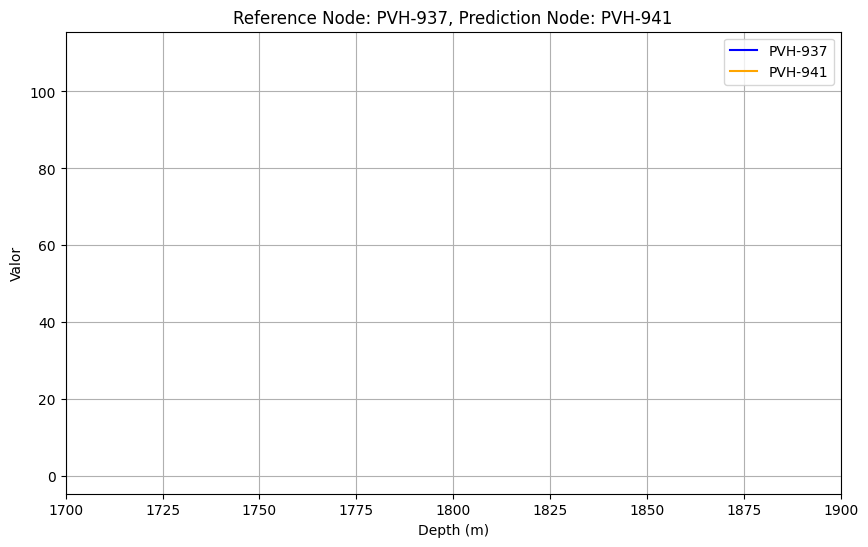

In [458]:


calc_tops(G, "PVH-937", "PVH-941")

def generate_ranges(start, end, step):
    return [(i, i + step) for i in range(start, end, step)]

ranges = generate_ranges(900, 1800, 200)

for r in ranges:
    profiles_comparison(G, "PVH-937", "PVH-941", list(r))


In [459]:
print(G.nodes["PVH-941"]["known_tops"])

    index Capa      Ref
0      32   C7   1018.3
1     224   C7     1026
2      34   C9   1036.5
3     226   C9   1044.8
4      47   K1   1091.8
5     239   K1   1109.2
6      52   K3   1150.3
7     244   K3   1156.4
8      53   K4   1162.7
9     245   K4   1170.7
10     57   K8   1204.3
11    249   K8   1212.9
12     58   K9   1219.3
13    250   K9   1223.5
14     59  K10   1233.4
15    251  K10   1236.9
16     65  K14   1250.3
17    257  K14   1257.3
18     69  K17   1270.4
19    261  K17   1274.6
20     72   L3   1279.2
21    264   L3   1287.1
22     73   L4     1298
23    265   L4   1303.4
24     86   M1   1397.1
25    278   M1   1400.9
26     89  M2A   1410.8
27    281  M2A   1416.6
28     95   M6  1438.38
29    287   M6  1440.64
30     96  M6A     1452
31    288  M6A   1460.6
32     99   M8   1473.4
33    291   M8   1477.9
34    100  M8a  1488.36
35    292  M8a  1491.21
36    101  M8b   1495.2
37    293  M8b   1499.3
38    108  M11   1528.1
39    300  M11   1531.6
40    116   O4  

In [460]:
print(G.nodes["PVH-941"]["tops"])

   Capa        Ref
0   NaN  1026.2500
1   NaN  1032.1250
2   NaN  1039.5000
3   NaN  1045.3750
4   NaN  1091.7500
5   NaN  1110.7500
6   NaN  1152.7500
7   NaN  1158.8750
8   NaN  1163.7500
9   NaN  1170.5000
10  NaN  1205.6250
11  NaN  1213.2500
12  NaN  1220.2500
13  NaN  1223.5000
14  NaN  1233.3750
15  NaN  1237.3750
16  NaN  1250.7500
17  NaN  1258.2500
18  NaN  1271.2500
19  NaN  1275.7500
20  NaN  1279.3750
21  NaN  1289.3750
22  NaN  1300.0000
23  NaN  1302.2500
24  NaN  1380.0000
25  NaN  1380.1250
26  NaN  1422.2500
27  NaN  1430.1250
28  NaN  1457.7500
29  NaN  1460.3750
30  NaN  1463.5000
31  NaN  1466.6250
32  NaN  1490.6250
33  NaN  1493.7500
34  NaN  1534.2500
35  NaN  1541.6250
36  NaN  1545.2500
37  NaN  1550.6250
38  NaN  1554.8125
39  NaN  1558.3750
40  NaN  1561.8750
41  NaN  1566.7500
